In [4]:
!pip install optuna==3.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 4.4 MB/s eta 0:00:00


In [1]:
!pip install visualkeras

In [55]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import optuna
from optuna.integration import TFKerasPruningCallback
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras.optimizers import Adam
import visualkeras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# **LOAD DATA**

In [7]:
train_dir = "/content/drive/MyDrive/Urban_Sound/images"

In [24]:
def load_images(directory):
    images = []
    labels = []
    successed = 0
    fail = 0
    try:
      for idx, label in enumerate(uniq_labels):
          for file in os.listdir(directory + "/" + label):
              filepath = directory + "/" + label + "/" + file
              image = cv2.resize(cv2.imread(filepath), (64, 64))
              image = image/255
              images.append(image)
              labels.append(idx)
              print(f"\r File Name: {file} - Successed: {successed}", end="")
              successed +=1
      images = np.array(images)
      labels = np.array(labels)
    except:
      fail +=1
      print(fail)
    return(images, labels)

In [25]:
uniq_labels = sorted(os.listdir(train_dir))
images, labels = load_images(directory = train_dir)

 File Name: 99710-9-0-5.png - Successed: 8731

In [26]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, random_state=42, test_size = 0.1, stratify = labels)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, random_state=42, test_size = 0.11)

n = len(uniq_labels)
train_n = len(X_train)
test_n = len(X_test)
eval_n = len(X_eval)

print("Total number of classes: ", n)
print("Number of training images: " , train_n)
print("Number of testing images: ", test_n)
print("Number of evaluation images: ", eval_n)

Total number of classes:  10
Number of training images:  6993
Number of testing images:  874
Number of evaluation images:  865


In [27]:
y_train = keras.utils.np_utils.to_categorical(y_train)
y_test = keras.utils.np_utils.to_categorical(y_test)
y_eval = keras.utils.np_utils.to_categorical(y_eval)

# **TUNING**

In [29]:
#define the CNN model
def create_model(trial):

    # Hyperparameters to be tuned by Optuna.
    num_cnn_blocks = trial.suggest_int("num_cnn_blocks", 2, 5)
    num_dense_nodes = int(trial.suggest_categorical("num_dense_nodes", [64, 128, 256, 512]))
    num_filters = [int(trial.suggest_categorical("units"+str(i), [64, 128, 256])) for i in range(num_cnn_blocks)]
    kernel_size = trial.suggest_int('kernel_size', 2, 4)
    dropout_rate = trial.suggest_float('dropout_rate', 0.05, 0.5, step=0.05)
    final_dropout_rate = trial.suggest_float('final_dropout_rate', 0.05, 0.5, step=0.05)
    #optimizer = trial.suggest_categorical("optimizer", ["sgd", "adam"])
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True)

    #MODEL
    model = Sequential()
    model.add(Conv2D(filters = num_filters[0], kernel_size = kernel_size, activation="relu", input_shape=(64, 64, 3)))
    model.add(Conv2D(filters = num_filters[0], kernel_size = kernel_size, activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.BatchNormalization())

    for i in range(1,num_cnn_blocks):
        model.add(Conv2D(filters = num_filters[i], kernel_size = kernel_size, padding = "same", activation = "relu"))
        model.add(Conv2D(filters = num_filters[i], kernel_size = kernel_size, padding = "same", activation = "relu"))
        model.add(MaxPooling2D(pool_size = (2, 2))) if num_cnn_blocks >= 4 else model.add(MaxPooling2D(pool_size = (4, 4)))
        model.add(keras.layers.BatchNormalization())
        model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(num_dense_nodes))
    model.add(Dropout(final_dropout_rate))

    model.add(Dense(10, activation='softmax'))
    #model.summary()

    model.compile(optimizer = Adam(learning_rate = learning_rate), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [30]:
def objective(trial):

    print("\n******************************Optimize Start******************************")
    keras.backend.clear_session()

    model = create_model(trial)

    callbacks = [ ReduceLROnPlateau(monitor='val_loss',
                                patience=3,
                                cooldown=1),
                  EarlyStopping(monitor='val_loss',
                                min_delta=1e-4,
                                patience=5),
                 TFKerasPruningCallback(trial, "val_accuracy")]

    batch_size = trial.suggest_categorical('batch_size', [64, 128])

    history = model.fit(X_train, y_train, epochs = 20, batch_size = batch_size, verbose = 2, callbacks= callbacks, validation_data = (X_eval , y_eval))
    return history.history["val_accuracy"][-1]

In [31]:
def show_result(study):

    complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
    pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("\nBest trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [32]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2023-08-17 10:44:18,038] A new study created in memory with name: no-name-6c279fc9-b02b-4d2d-baeb-38e9f4d0e77a



******************************Optimize Start******************************
Epoch 1/20
110/110 - 20s - loss: 64.6213 - accuracy: 0.3180 - val_loss: 20.0438 - val_accuracy: 0.3503 - lr: 0.0239 - 20s/epoch - 184ms/step
Epoch 2/20
110/110 - 8s - loss: 2.9887 - accuracy: 0.4227 - val_loss: 2.9162 - val_accuracy: 0.4081 - lr: 0.0239 - 8s/epoch - 75ms/step
Epoch 3/20
110/110 - 8s - loss: 1.9031 - accuracy: 0.4620 - val_loss: 1.6617 - val_accuracy: 0.5272 - lr: 0.0239 - 8s/epoch - 75ms/step
Epoch 4/20
110/110 - 8s - loss: 1.7167 - accuracy: 0.4863 - val_loss: 1.8095 - val_accuracy: 0.4636 - lr: 0.0239 - 8s/epoch - 76ms/step
Epoch 5/20
110/110 - 8s - loss: 1.6635 - accuracy: 0.4929 - val_loss: 1.7461 - val_accuracy: 0.4647 - lr: 0.0239 - 8s/epoch - 76ms/step
Epoch 6/20
110/110 - 8s - loss: 1.5819 - accuracy: 0.5179 - val_loss: 1.6900 - val_accuracy: 0.5075 - lr: 0.0239 - 8s/epoch - 77ms/step
Epoch 7/20
110/110 - 9s - loss: 1.0873 - accuracy: 0.6381 - val_loss: 1.0842 - val_accuracy: 0.5988 - l

[I 2023-08-17 10:47:41,769] Trial 0 finished with value: 0.6635838150978088 and parameters: {'num_cnn_blocks': 2, 'num_dense_nodes': 512, 'units0': 128, 'units1': 128, 'kernel_size': 2, 'dropout_rate': 0.05, 'final_dropout_rate': 0.15000000000000002, 'learning_rate': 0.023909012826527527, 'batch_size': 64}. Best is trial 0 with value: 0.6635838150978088.



******************************Optimize Start******************************
Epoch 1/20
55/55 - 14s - loss: 2.7906 - accuracy: 0.1915 - val_loss: 2.3673 - val_accuracy: 0.1006 - lr: 4.2883e-04 - 14s/epoch - 247ms/step
Epoch 2/20
55/55 - 8s - loss: 2.1618 - accuracy: 0.2847 - val_loss: 2.6343 - val_accuracy: 0.1156 - lr: 4.2883e-04 - 8s/epoch - 146ms/step
Epoch 3/20
55/55 - 8s - loss: 1.8658 - accuracy: 0.3611 - val_loss: 3.6798 - val_accuracy: 0.1168 - lr: 4.2883e-04 - 8s/epoch - 144ms/step
Epoch 4/20
55/55 - 8s - loss: 1.7095 - accuracy: 0.4223 - val_loss: 3.6142 - val_accuracy: 0.1156 - lr: 4.2883e-04 - 8s/epoch - 144ms/step
Epoch 5/20
55/55 - 8s - loss: 1.5815 - accuracy: 0.4539 - val_loss: 3.7420 - val_accuracy: 0.1318 - lr: 4.2883e-05 - 8s/epoch - 146ms/step
Epoch 6/20
55/55 - 8s - loss: 1.5819 - accuracy: 0.4637 - val_loss: 3.8838 - val_accuracy: 0.1098 - lr: 4.2883e-05 - 8s/epoch - 146ms/step


[I 2023-08-17 10:48:36,717] Trial 1 finished with value: 0.10982658714056015 and parameters: {'num_cnn_blocks': 5, 'num_dense_nodes': 256, 'units0': 128, 'units1': 64, 'units2': 64, 'units3': 128, 'units4': 128, 'kernel_size': 2, 'dropout_rate': 0.45, 'final_dropout_rate': 0.4, 'learning_rate': 0.0004288298089127638, 'batch_size': 128}. Best is trial 0 with value: 0.6635838150978088.



******************************Optimize Start******************************
Epoch 1/20
110/110 - 31s - loss: 5.5761 - accuracy: 0.2039 - val_loss: 7.0806 - val_accuracy: 0.1965 - lr: 0.0702 - 31s/epoch - 282ms/step
Epoch 2/20
110/110 - 25s - loss: 2.0866 - accuracy: 0.3000 - val_loss: 7.5703 - val_accuracy: 0.1214 - lr: 0.0702 - 25s/epoch - 229ms/step
Epoch 3/20
110/110 - 25s - loss: 2.0396 - accuracy: 0.3504 - val_loss: 8.6588 - val_accuracy: 0.1792 - lr: 0.0702 - 25s/epoch - 228ms/step
Epoch 4/20
110/110 - 26s - loss: 2.2806 - accuracy: 0.3232 - val_loss: 3.2107 - val_accuracy: 0.2335 - lr: 0.0702 - 26s/epoch - 232ms/step
Epoch 5/20
110/110 - 26s - loss: 2.3800 - accuracy: 0.3358 - val_loss: 3.2594 - val_accuracy: 0.2994 - lr: 0.0702 - 26s/epoch - 233ms/step
Epoch 6/20
110/110 - 25s - loss: 6.0835 - accuracy: 0.2843 - val_loss: 6779.4541 - val_accuracy: 0.0948 - lr: 0.0702 - 25s/epoch - 226ms/step
Epoch 7/20
110/110 - 25s - loss: 42.3527 - accuracy: 0.1427 - val_loss: 17.0649 - val_a

[I 2023-08-17 10:53:00,495] Trial 2 finished with value: 0.11329479515552521 and parameters: {'num_cnn_blocks': 4, 'num_dense_nodes': 128, 'units0': 256, 'units1': 256, 'units2': 128, 'units3': 64, 'kernel_size': 2, 'dropout_rate': 0.5, 'final_dropout_rate': 0.35000000000000003, 'learning_rate': 0.07021750078527535, 'batch_size': 64}. Best is trial 0 with value: 0.6635838150978088.



******************************Optimize Start******************************
Epoch 1/20
110/110 - 16s - loss: 1.4080 - accuracy: 0.5145 - val_loss: 2.5710 - val_accuracy: 0.2682 - lr: 0.0011 - 16s/epoch - 149ms/step
Epoch 2/20
110/110 - 11s - loss: 0.8471 - accuracy: 0.7164 - val_loss: 2.9941 - val_accuracy: 0.1908 - lr: 0.0011 - 11s/epoch - 104ms/step
Epoch 3/20
110/110 - 11s - loss: 0.6317 - accuracy: 0.7919 - val_loss: 0.9755 - val_accuracy: 0.6555 - lr: 0.0011 - 11s/epoch - 103ms/step
Epoch 4/20
110/110 - 11s - loss: 0.4923 - accuracy: 0.8308 - val_loss: 0.7533 - val_accuracy: 0.7688 - lr: 0.0011 - 11s/epoch - 103ms/step
Epoch 5/20
110/110 - 11s - loss: 0.3681 - accuracy: 0.8777 - val_loss: 0.5912 - val_accuracy: 0.8208 - lr: 0.0011 - 11s/epoch - 104ms/step
Epoch 6/20
110/110 - 11s - loss: 0.3426 - accuracy: 0.8853 - val_loss: 0.5889 - val_accuracy: 0.8046 - lr: 0.0011 - 11s/epoch - 104ms/step
Epoch 7/20
110/110 - 11s - loss: 0.2527 - accuracy: 0.9172 - val_loss: 0.5196 - val_accura

[I 2023-08-17 10:57:25,064] Trial 3 finished with value: 0.9236994385719299 and parameters: {'num_cnn_blocks': 3, 'num_dense_nodes': 512, 'units0': 128, 'units1': 128, 'units2': 64, 'kernel_size': 4, 'dropout_rate': 0.1, 'final_dropout_rate': 0.35000000000000003, 'learning_rate': 0.0010728032930507358, 'batch_size': 64}. Best is trial 3 with value: 0.9236994385719299.



******************************Optimize Start******************************
Epoch 1/20
110/110 - 15s - loss: 1.6409 - accuracy: 0.4379 - val_loss: 3.2770 - val_accuracy: 0.1711 - lr: 0.0018 - 15s/epoch - 134ms/step
Epoch 2/20
110/110 - 9s - loss: 1.0408 - accuracy: 0.6425 - val_loss: 2.3278 - val_accuracy: 0.2382 - lr: 0.0018 - 9s/epoch - 81ms/step
Epoch 3/20
110/110 - 9s - loss: 0.8056 - accuracy: 0.7319 - val_loss: 2.5585 - val_accuracy: 0.2751 - lr: 0.0018 - 9s/epoch - 81ms/step
Epoch 4/20
110/110 - 9s - loss: 0.6360 - accuracy: 0.7919 - val_loss: 1.3162 - val_accuracy: 0.6532 - lr: 0.0018 - 9s/epoch - 80ms/step
Epoch 5/20
110/110 - 9s - loss: 0.5378 - accuracy: 0.8224 - val_loss: 0.9707 - val_accuracy: 0.6751 - lr: 0.0018 - 9s/epoch - 80ms/step
Epoch 6/20
110/110 - 9s - loss: 0.4407 - accuracy: 0.8594 - val_loss: 2.1274 - val_accuracy: 0.5029 - lr: 0.0018 - 9s/epoch - 80ms/step
Epoch 7/20
110/110 - 9s - loss: 0.4206 - accuracy: 0.8666 - val_loss: 0.5023 - val_accuracy: 0.8451 - lr:

[I 2023-08-17 11:00:59,778] Trial 4 finished with value: 0.9375722408294678 and parameters: {'num_cnn_blocks': 5, 'num_dense_nodes': 64, 'units0': 128, 'units1': 128, 'units2': 64, 'units3': 256, 'units4': 64, 'kernel_size': 3, 'dropout_rate': 0.15000000000000002, 'final_dropout_rate': 0.2, 'learning_rate': 0.0017875649245744493, 'batch_size': 64}. Best is trial 4 with value: 0.9375722408294678.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:01:35,310] Trial 5 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:02:11,722] Trial 6 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20
110/110 - 21s - loss: 49.1568 - accuracy: 0.3136 - val_loss: 13.0032 - val_accuracy: 0.3214 - lr: 0.0154 - 21s/epoch - 189ms/step
Epoch 2/20
110/110 - 16s - loss: 4.8440 - accuracy: 0.3841 - val_loss: 4.9279 - val_accuracy: 0.3780 - lr: 0.0154 - 16s/epoch - 145ms/step
Epoch 3/20
110/110 - 16s - loss: 4.1657 - accuracy: 0.4107 - val_loss: 3.1177 - val_accuracy: 0.3757 - lr: 0.0154 - 16s/epoch - 145ms/step
Epoch 4/20


[I 2023-08-17 11:03:33,148] Trial 7 pruned. Trial was pruned at epoch 3.



******************************Optimize Start******************************
Epoch 1/20
55/55 - 46s - loss: 2.9249 - accuracy: 0.2577 - val_loss: 46.1163 - val_accuracy: 0.2185 - lr: 0.0046 - 46s/epoch - 834ms/step
Epoch 2/20
55/55 - 20s - loss: 1.7334 - accuracy: 0.4097 - val_loss: 3.0151 - val_accuracy: 0.3364 - lr: 0.0046 - 20s/epoch - 370ms/step
Epoch 3/20
55/55 - 20s - loss: 1.4422 - accuracy: 0.5056 - val_loss: 1.7766 - val_accuracy: 0.4497 - lr: 0.0046 - 20s/epoch - 365ms/step
Epoch 4/20


[I 2023-08-17 11:05:20,734] Trial 8 pruned. Trial was pruned at epoch 3.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:05:31,933] Trial 9 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:05:41,746] Trial 10 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:05:56,441] Trial 11 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20
110/110 - 14s - loss: 1.9476 - accuracy: 0.3478 - val_loss: 1.9102 - val_accuracy: 0.2936 - lr: 0.0019 - 14s/epoch - 123ms/step
Epoch 2/20
110/110 - 11s - loss: 1.3083 - accuracy: 0.5504 - val_loss: 1.9305 - val_accuracy: 0.3214 - lr: 0.0019 - 11s/epoch - 104ms/step
Epoch 3/20
110/110 - 11s - loss: 0.9949 - accuracy: 0.6595 - val_loss: 1.1810 - val_accuracy: 0.5780 - lr: 0.0019 - 11s/epoch - 103ms/step
Epoch 4/20
110/110 - 11s - loss: 0.7793 - accuracy: 0.7393 - val_loss: 1.3005 - val_accuracy: 0.5699 - lr: 0.0019 - 11s/epoch - 104ms/step
Epoch 5/20
110/110 - 11s - loss: 0.6623 - accuracy: 0.7862 - val_loss: 1.7345 - val_accuracy: 0.5803 - lr: 0.0019 - 11s/epoch - 104ms/step
Epoch 6/20
110/110 - 11s - loss: 0.5357 - accuracy: 0.8307 - val_loss: 0.5534 - val_accuracy: 0.8069 - lr: 0.0019 - 11s/epoch - 104ms/step
Epoch 7/20
110/110 - 11s - loss: 0.4333 - accuracy: 0.8580 - val_loss: 0.6722 - val_accura

[I 2023-08-17 11:08:17,883] Trial 12 pruned. Trial was pruned at epoch 11.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:08:48,759] Trial 13 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:09:13,916] Trial 14 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:09:34,616] Trial 15 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:09:51,419] Trial 16 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:10:10,882] Trial 17 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:10:50,007] Trial 18 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20
110/110 - 12s - loss: 9.0571 - accuracy: 0.3638 - val_loss: 8.5516 - val_accuracy: 0.2751 - lr: 0.0026 - 12s/epoch - 112ms/step
Epoch 2/20
110/110 - 10s - loss: 3.2786 - accuracy: 0.5352 - val_loss: 2.6353 - val_accuracy: 0.4416 - lr: 0.0026 - 10s/epoch - 94ms/step
Epoch 3/20
110/110 - 10s - loss: 1.4811 - accuracy: 0.6531 - val_loss: 1.0828 - val_accuracy: 0.6451 - lr: 0.0026 - 10s/epoch - 95ms/step
Epoch 4/20
110/110 - 11s - loss: 0.8662 - accuracy: 0.7539 - val_loss: 0.7454 - val_accuracy: 0.7642 - lr: 0.0026 - 11s/epoch - 96ms/step
Epoch 5/20
110/110 - 11s - loss: 0.6574 - accuracy: 0.8035 - val_loss: 1.2194 - val_accuracy: 0.6231 - lr: 0.0026 - 11s/epoch - 96ms/step
Epoch 6/20
110/110 - 11s - loss: 0.5439 - accuracy: 0.8238 - val_loss: 0.5372 - val_accuracy: 0.8347 - lr: 0.0026 - 11s/epoch - 97ms/step
Epoch 7/20
110/110 - 11s - loss: 0.4214 - accuracy: 0.8569 - val_loss: 0.5661 - val_accuracy: 0

[I 2023-08-17 11:12:51,994] Trial 19 pruned. Trial was pruned at epoch 10.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:13:28,553] Trial 20 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:13:41,901] Trial 21 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20
110/110 - 10s - loss: 25.3844 - accuracy: 0.3739 - val_loss: 4.4921 - val_accuracy: 0.4740 - lr: 0.0109 - 10s/epoch - 93ms/step
Epoch 2/20
110/110 - 9s - loss: 2.5833 - accuracy: 0.4988 - val_loss: 3.7764 - val_accuracy: 0.3630 - lr: 0.0109 - 9s/epoch - 83ms/step
Epoch 3/20
110/110 - 9s - loss: 2.0911 - accuracy: 0.5536 - val_loss: 2.0470 - val_accuracy: 0.5445 - lr: 0.0109 - 9s/epoch - 83ms/step
Epoch 4/20
110/110 - 9s - loss: 2.3471 - accuracy: 0.5704 - val_loss: 2.8859 - val_accuracy: 0.5514 - lr: 0.0109 - 9s/epoch - 81ms/step
Epoch 5/20
110/110 - 9s - loss: 2.5650 - accuracy: 0.5863 - val_loss: 2.8135 - val_accuracy: 0.5757 - lr: 0.0109 - 9s/epoch - 81ms/step
Epoch 6/20
110/110 - 9s - loss: 1.7339 - accuracy: 0.6578 - val_loss: 1.6373 - val_accuracy: 0.6035 - lr: 0.0109 - 9s/epoch - 80ms/step
Epoch 7/20


[I 2023-08-17 11:14:47,088] Trial 22 pruned. Trial was pruned at epoch 6.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:14:58,201] Trial 23 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:15:09,154] Trial 24 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:15:20,497] Trial 25 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:15:37,597] Trial 26 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20
110/110 - 12s - loss: 6.4820 - accuracy: 0.3751 - val_loss: 9.6911 - val_accuracy: 0.2416 - lr: 0.0035 - 12s/epoch - 110ms/step
Epoch 2/20
110/110 - 11s - loss: 2.1406 - accuracy: 0.5251 - val_loss: 1.7262 - val_accuracy: 0.5133 - lr: 0.0035 - 11s/epoch - 102ms/step
Epoch 3/20
110/110 - 11s - loss: 1.1412 - accuracy: 0.6461 - val_loss: 1.4327 - val_accuracy: 0.5595 - lr: 0.0035 - 11s/epoch - 102ms/step
Epoch 4/20
110/110 - 11s - loss: 0.8630 - accuracy: 0.7180 - val_loss: 1.2009 - val_accuracy: 0.6405 - lr: 0.0035 - 11s/epoch - 101ms/step
Epoch 5/20
110/110 - 11s - loss: 0.7017 - accuracy: 0.7653 - val_loss: 0.7742 - val_accuracy: 0.7422 - lr: 0.0035 - 11s/epoch - 100ms/step
Epoch 6/20
110/110 - 11s - loss: 0.6132 - accuracy: 0.7957 - val_loss: 0.8337 - val_accuracy: 0.7121 - lr: 0.0035 - 11s/epoch - 99ms/step
Epoch 7/20
110/110 - 11s - loss: 0.5424 - accuracy: 0.8172 - val_loss: 1.8775 - val_accurac

[I 2023-08-17 11:17:37,747] Trial 27 pruned. Trial was pruned at epoch 9.



******************************Optimize Start******************************
Epoch 1/20
110/110 - 6s - loss: 1.6311 - accuracy: 0.4567 - val_loss: 3.5938 - val_accuracy: 0.2289 - lr: 0.0069 - 6s/epoch - 51ms/step
Epoch 2/20
110/110 - 4s - loss: 1.1988 - accuracy: 0.5844 - val_loss: 1.8613 - val_accuracy: 0.4012 - lr: 0.0069 - 4s/epoch - 34ms/step
Epoch 3/20
110/110 - 4s - loss: 1.0140 - accuracy: 0.6488 - val_loss: 0.9904 - val_accuracy: 0.6428 - lr: 0.0069 - 4s/epoch - 34ms/step
Epoch 4/20
110/110 - 4s - loss: 0.8836 - accuracy: 0.6953 - val_loss: 0.9007 - val_accuracy: 0.6948 - lr: 0.0069 - 4s/epoch - 34ms/step
Epoch 5/20
110/110 - 4s - loss: 0.7646 - accuracy: 0.7400 - val_loss: 1.4084 - val_accuracy: 0.6058 - lr: 0.0069 - 4s/epoch - 35ms/step
Epoch 6/20
110/110 - 4s - loss: 0.7212 - accuracy: 0.7568 - val_loss: 1.0308 - val_accuracy: 0.6775 - lr: 0.0069 - 4s/epoch - 36ms/step
Epoch 7/20


[I 2023-08-17 11:18:38,028] Trial 28 pruned. Trial was pruned at epoch 6.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:19:29,381] Trial 29 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:19:40,210] Trial 30 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:20:10,085] Trial 31 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:20:53,324] Trial 32 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:21:21,389] Trial 33 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:21:49,057] Trial 34 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:22:03,553] Trial 35 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:22:42,120] Trial 36 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:22:53,370] Trial 37 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:23:04,874] Trial 38 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20
110/110 - 14s - loss: 3.7803 - accuracy: 0.2697 - val_loss: 2.7720 - val_accuracy: 0.2150 - lr: 0.0046 - 14s/epoch - 131ms/step
Epoch 2/20
110/110 - 12s - loss: 1.8975 - accuracy: 0.3882 - val_loss: 3.5480 - val_accuracy: 0.2092 - lr: 0.0046 - 12s/epoch - 109ms/step
Epoch 3/20
110/110 - 12s - loss: 1.3669 - accuracy: 0.5272 - val_loss: 1.2211 - val_accuracy: 0.5884 - lr: 0.0046 - 12s/epoch - 110ms/step
Epoch 4/20
110/110 - 12s - loss: 1.2005 - accuracy: 0.5936 - val_loss: 1.4261 - val_accuracy: 0.5202 - lr: 0.0046 - 12s/epoch - 110ms/step
Epoch 5/20
110/110 - 12s - loss: 1.0597 - accuracy: 0.6458 - val_loss: 1.0433 - val_accuracy: 0.6486 - lr: 0.0046 - 12s/epoch - 110ms/step
Epoch 6/20
110/110 - 12s - loss: 0.9580 - accuracy: 0.6807 - val_loss: 1.1212 - val_accuracy: 0.6162 - lr: 0.0046 - 12s/epoch - 109ms/step
Epoch 7/20


[I 2023-08-17 11:24:33,361] Trial 39 pruned. Trial was pruned at epoch 6.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:24:57,505] Trial 40 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:25:27,714] Trial 41 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:25:40,240] Trial 42 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:25:51,311] Trial 43 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:26:03,079] Trial 44 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:26:16,451] Trial 45 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20
110/110 - 6s - loss: 3.2080 - accuracy: 0.4240 - val_loss: 1.7586 - val_accuracy: 0.4127 - lr: 0.0025 - 6s/epoch - 54ms/step
Epoch 2/20
110/110 - 4s - loss: 1.4184 - accuracy: 0.6163 - val_loss: 2.1205 - val_accuracy: 0.2855 - lr: 0.0025 - 4s/epoch - 39ms/step
Epoch 3/20
110/110 - 4s - loss: 0.9629 - accuracy: 0.7037 - val_loss: 1.1381 - val_accuracy: 0.6197 - lr: 0.0025 - 4s/epoch - 40ms/step
Epoch 4/20
110/110 - 4s - loss: 0.6628 - accuracy: 0.7889 - val_loss: 0.7640 - val_accuracy: 0.7422 - lr: 0.0025 - 4s/epoch - 39ms/step
Epoch 5/20
110/110 - 4s - loss: 0.5456 - accuracy: 0.8177 - val_loss: 0.8469 - val_accuracy: 0.7376 - lr: 0.0025 - 4s/epoch - 39ms/step
Epoch 6/20
110/110 - 5s - loss: 0.4813 - accuracy: 0.8404 - val_loss: 0.5863 - val_accuracy: 0.8358 - lr: 0.0025 - 5s/epoch - 41ms/step
Epoch 7/20
110/110 - 4s - loss: 0.4142 - accuracy: 0.8599 - val_loss: 0.7859 - val_accuracy: 0.7780 - lr: 0.

[I 2023-08-17 11:27:07,939] Trial 46 pruned. Trial was pruned at epoch 10.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:27:51,874] Trial 47 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20


[I 2023-08-17 11:28:18,472] Trial 48 pruned. Trial was pruned at epoch 0.



******************************Optimize Start******************************
Epoch 1/20
110/110 - 9s - loss: 4.8446 - accuracy: 0.3063 - val_loss: 2.9160 - val_accuracy: 0.2023 - lr: 0.0038 - 9s/epoch - 86ms/step
Epoch 2/20
110/110 - 8s - loss: 1.4992 - accuracy: 0.5169 - val_loss: 2.5748 - val_accuracy: 0.1387 - lr: 0.0038 - 8s/epoch - 72ms/step
Epoch 3/20
110/110 - 8s - loss: 1.0916 - accuracy: 0.6319 - val_loss: 2.3781 - val_accuracy: 0.4092 - lr: 0.0038 - 8s/epoch - 73ms/step
Epoch 4/20
110/110 - 8s - loss: 0.8957 - accuracy: 0.7017 - val_loss: 1.8134 - val_accuracy: 0.4879 - lr: 0.0038 - 8s/epoch - 74ms/step
Epoch 5/20
110/110 - 8s - loss: 0.7581 - accuracy: 0.7497 - val_loss: 0.7360 - val_accuracy: 0.7618 - lr: 0.0038 - 8s/epoch - 73ms/step
Epoch 6/20
110/110 - 8s - loss: 0.6786 - accuracy: 0.7782 - val_loss: 0.9536 - val_accuracy: 0.7133 - lr: 0.0038 - 8s/epoch - 74ms/step
Epoch 7/20
110/110 - 8s - loss: 0.5824 - accuracy: 0.8108 - val_loss: 1.1455 - val_accuracy: 0.6867 - lr: 0.

[I 2023-08-17 11:30:14,001] Trial 49 pruned. Trial was pruned at epoch 11.


In [33]:
show_result(study)

Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  45
  Number of complete trials:  5

Best trial:
  Value:  0.9375722408294678
  Params: 
    num_cnn_blocks: 5
    num_dense_nodes: 64
    units0: 128
    units1: 128
    units2: 64
    units3: 256
    units4: 64
    kernel_size: 3
    dropout_rate: 0.15000000000000002
    final_dropout_rate: 0.2
    learning_rate: 0.0017875649245744493
    batch_size: 64


In [34]:
df_results = study.trials_dataframe()
df_results

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout_rate,params_final_dropout_rate,params_kernel_size,params_learning_rate,params_num_cnn_blocks,params_num_dense_nodes,params_units0,params_units1,params_units2,params_units3,params_units4,state
0,0,0.663584,2023-08-17 10:44:18.045529,2023-08-17 10:47:41.768786,0 days 00:03:23.723257,64,0.05,0.15,2,0.023909,2,512,128,128,NaN,NaN,NaN,COMPLETE
1,1,0.109827,2023-08-17 10:47:41.770927,2023-08-17 10:48:36.716964,0 days 00:00:54.946037,128,0.45,0.40,2,0.000429,5,256,128,64,64.0,128.0,128.0,COMPLETE
2,2,0.113295,2023-08-17 10:48:36.721518,2023-08-17 10:53:00.494563,0 days 00:04:23.773045,64,0.50,0.35,2,0.070218,4,128,256,256,128.0,64.0,NaN,COMPLETE
3,3,0.923699,2023-08-17 10:53:00.499822,2023-08-17 10:57:25.064314,0 days 00:04:24.564492,64,0.10,0.35,4,0.001073,3,512,128,128,64.0,NaN,NaN,COMPLETE
4,4,0.937572,2023-08-17 10:57:25.069095,2023-08-17 11:00:59.777533,0 days 00:03:34.708438,64,0.15,0.20,3,0.001788,5,64,128,128,64.0,256.0,64.0,COMPLETE
5,5,0.168786,2023-08-17 11:00:59.780382,2023-08-17 11:01:35.310142,0 days 00:00:35.529760,128,0.45,0.35,3,0.000988,3,512,128,128,64.0,NaN,NaN,PRUNED
6,6,0.124855,2023-08-17 11:01:35.311758,2023-08-17 11:02:11.721940,0 days 00:00:36.410182,128,0.45,0.45,4,0.090616,2,512,128,256,NaN,NaN,NaN,PRUNED
7,7,0.304046,2023-08-17 11:02:11.724147,2023-08-17 11:03:33.147999,0 days 00:01:21.423852,64,0.50,0.05,4,0.015420,2,512,128,256,NaN,NaN,NaN,PRUNED
8,8,0.332948,2023-08-17 11:03:33.153312,2023-08-17 11:05:20.734486,0 days 00:01:47.581174,128,0.35,0.35,4,0.004572,4,256,256,64,64.0,64.0,NaN,PRUNED
9,9,0.126012,2023-08-17 11:05:20.737483,2023-08-17 11:05:31.933518,0 days 00:00:11.196035,64,0.35,0.25,3,0.000144,4,128,64,128,256.0,128.0,NaN,PRUNED


# **VISUALIZATION**

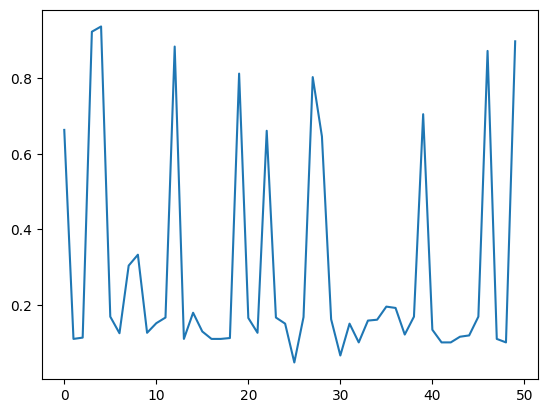

In [35]:
plt.plot([t.value for t in study.trials])

In [36]:
optuna.visualization.plot_contour(study)

In [37]:
optuna.visualization.plot_param_importances(study)

In [38]:
optuna.visualization.plot_optimization_history(study)

In [39]:
optuna.visualization.plot_intermediate_values(study)

In [40]:
optuna.visualization.plot_contour(study, params=["dropout_rate","num_cnn_blocks","final_dropout_rate","learning_rate"])

In [41]:
optuna.visualization.plot_parallel_coordinate(study)

In [42]:
optuna.visualization.plot_slice(study)

# **COMPILE MODEL**

In [57]:
model = Sequential()
model.add(Conv2D(filters = 128, kernel_size = 4, padding = 'same', activation = 'relu', input_shape = (64, 64, 3)))
model.add(Conv2D(filters = 128 , kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(keras.layers.BatchNormalization())


model.add(Conv2D(filters = 64 , kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64 , kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(keras.layers.BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128 , kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128 , kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(keras.layers.BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters = 256 , kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 256 , kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(keras.layers.BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128 , kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128 , kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(keras.layers.BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 64, 64, 128)       6272      
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 128)       262272    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 64)        131136    
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 64)       

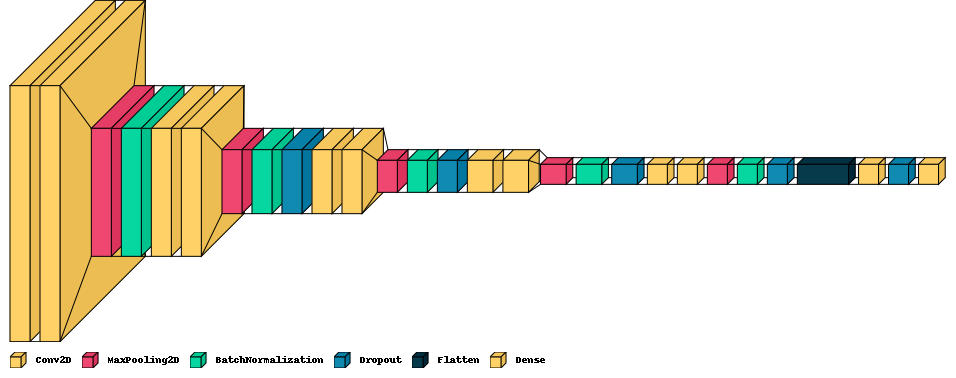

In [58]:
visualkeras.layered_view(model, legend=True, to_file='model_architecture.png')

In [59]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss',
                                patience=4,
                                cooldown=1),
              EarlyStopping(monitor='val_loss',
                            min_delta=1e-4,
                            patience=5)]

In [60]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.002), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [61]:
hist = model.fit(X_train, y_train, epochs = 100, batch_size = 64, callbacks = callbacks, validation_data = (X_eval , y_eval))

Epoch 1/100
110/110 [==============================] - 20s 167ms/step - loss: 2.5584 - accuracy: 0.3020 - val_loss: 7.2945 - val_accuracy: 0.1988 - lr: 0.0020
Epoch 2/100
110/110 [==============================] - 18s 167ms/step - loss: 1.9296 - accuracy: 0.4136 - val_loss: 1.9867 - val_accuracy: 0.3225 - lr: 0.0020
Epoch 3/100
110/110 [==============================] - 18s 163ms/step - loss: 1.5072 - accuracy: 0.5221 - val_loss: 2.0577 - val_accuracy: 0.3306 - lr: 0.0020
Epoch 4/100
110/110 [==============================] - 18s 161ms/step - loss: 1.2165 - accuracy: 0.6070 - val_loss: 1.5493 - val_accuracy: 0.4763 - lr: 0.0020
Epoch 5/100
110/110 [==============================] - 18s 161ms/step - loss: 1.0483 - accuracy: 0.6635 - val_loss: 1.2961 - val_accuracy: 0.5584 - lr: 0.0020
Epoch 6/100
110/110 [==============================] - 18s 163ms/step - loss: 0.8876 - accuracy: 0.7164 - val_loss: 0.8779 - val_accuracy: 0.7052 - lr: 0.0020
Epoch 7/100
110/110 [=========================

# **MODEL PERFORMANCE**

In [62]:
score = model.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 92.563 %
Accuracy for evaluation images: 92.254 %


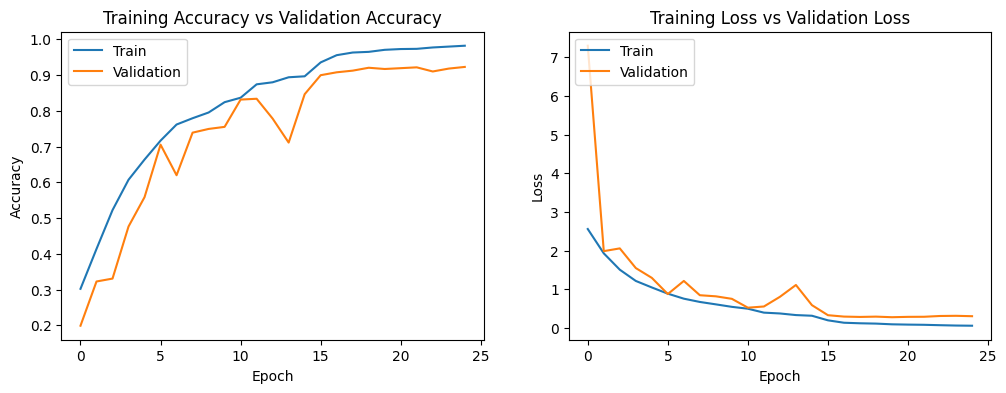

In [63]:
def plot_training(model_history):
  fig , ax = plt.subplots(1,2)
  train_acc = model_history.history['accuracy']
  train_loss = model_history.history['loss']
  fig.set_size_inches(12,4)

  ax[0].plot(model_history.history['accuracy'])
  ax[0].plot(model_history.history['val_accuracy'])
  ax[0].set_title('Training Accuracy vs Validation Accuracy')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['Train', 'Validation'], loc='upper left')

  ax[1].plot(model_history.history['loss'])
  ax[1].plot(model_history.history['val_loss'])
  ax[1].set_title('Training Loss vs Validation Loss')
  ax[1].set_ylabel('Loss')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['Train', 'Validation'], loc='upper left')

plot_training(hist)

28/28 [==============================] - 1s 22ms/step


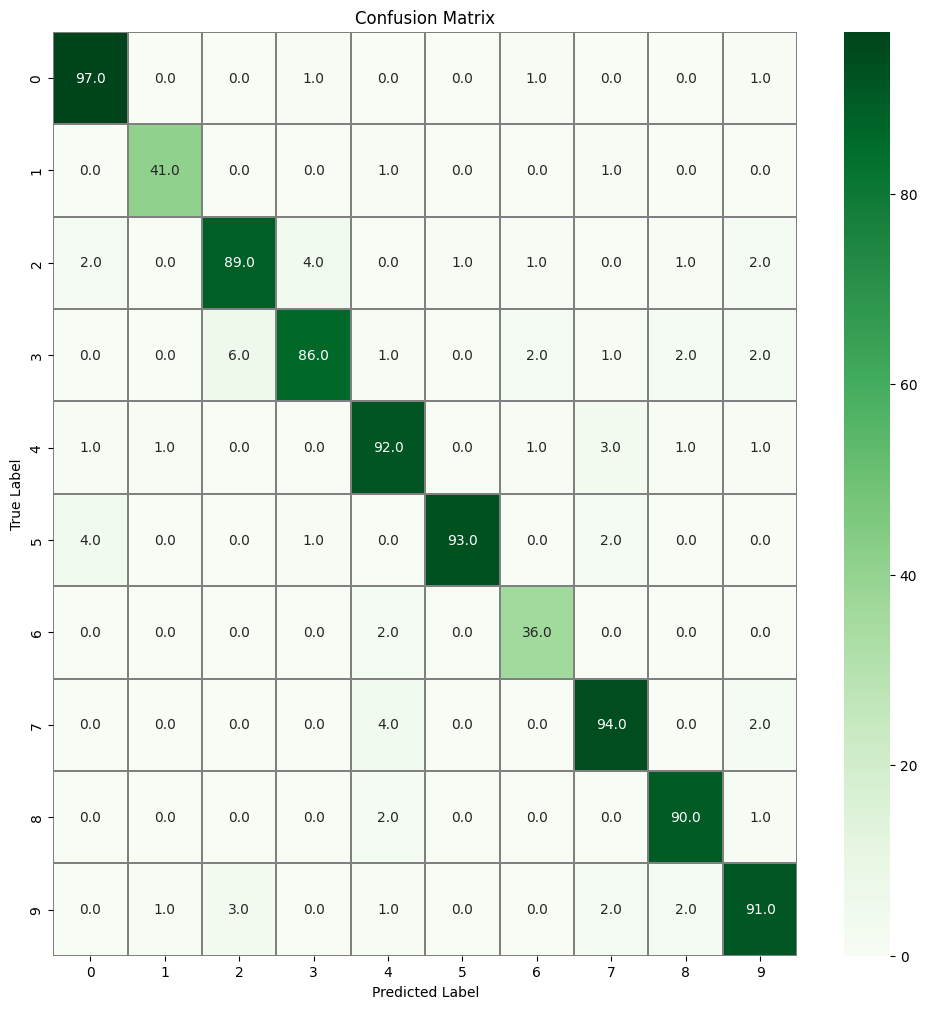

In [64]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1)
y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model.save("UrbanSound_CNN_94.5.h5")